# CS506 Midterm 2021 Spring


## 1. Preliminary analysis
The goal of the midterm is to predict the star rating associated with user reviews from Amazon Movie. There are 9 Columns -Id, ProductId, UserId, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text - in the dataset. The first step is to get intuitions about the data and find which features correlate to the ratings. The visualization tool and statistic analysis using Pandas library is helpful to get intuitions of which data should be normalized, vectorized, and encoded. The best way to predict the customer's rating is to become a customer, so I pretend to become one of the reviewer. I listed down the things that I would 




### 1.1 Score
The data is skewed to 5, meaning that there are way too many ratings of 5, which potentailly slows down the preprocessing process especially vectorizing the "Text" feature. We can balance the weights of ratings by setting the weight parameter while training the model . 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, KDTree, NearestCentroid, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

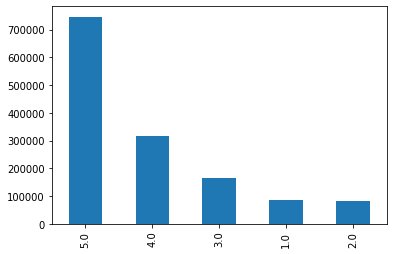

In [2]:
trainingSet['Score'].value_counts().plot.bar()

## 1.2 Missing Values
As we can see from the statistics, there are missing values on summary and text columns, but it does not required to preprocess since I'm discarding the Text and Summary features. 

In [19]:
print(trainingSet.isna().sum())

Id                             0
ProductId                      0
UserId                         0
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Score                     300000
Time                           0
Summary                       25
Text                          62
dtype: int64


## 1.3 Average ratings per users

It will be very useful to know the average rating per users, because we can see the patterns of each user. Such pattern will be useful to identify the linear relationship between the user and rating 

Text(0.5, 1.0, 'Top 15 average')

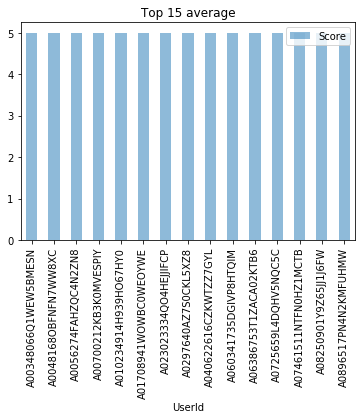

In [12]:
trainingSet[['Score', 'UserId']].groupby(['UserId']).mean().nlargest(15, 'Score').plot(kind = 'bar', legend = True, alpha =0.5)
plt.title("Top 15 average")

## 1.4 Frequent words

Although I did not use Text feature, it will be very useful to catch the top keywords


In [18]:
topWords = []
for i in range(1,6):
    words = pd.Series(word_tokenize(' '.join(trainingSet.where(trainingSet['Score'] == float(i))['Summary'].dropna()).lower())).value_counts()
    topWordsForScore = words.where(~words.index.isin(stopwords.words()))
    print("Top 30 words for score = ", i)
    print(topWordsForScore.nlargest(30).index.tolist())
    print()
    topWords.append(topWordsForScore)

Top 30 words for score =  1
['!', '.', ',', '...', 'movie', '?', "n't", 'bad', "'s", 'worst', 'boring', 'waste', 'time', 'film', 'ever', "''", '``', 'good', 'terrible', 'horrible', 'awful', '-', 'dvd', 'like', 'money', '&', ':', 'really', 'great', 'star']

Top 30 words for score =  2
[',', '.', '!', '...', 'movie', '?', "'s", 'good', "n't", 'bad', 'film', '``', "''", 'great', 'boring', 'disappointing', 'like', 'better', '-', 'much', '&', ';', 'story', ':', 'stars', 'dvd', 'time', 'really', 'could', 'poor']

Top 30 words for score =  3
[',', '.', '...', '!', 'good', 'movie', "'s", '?', 'great', 'film', "''", '``', 'bad', "n't", 'ok', 'better', 'fun', '-', 'story', '&', 'okay', 'stars', ';', 'dvd', 'like', ':', 'best', 'interesting', 'much', 'could']

Top 30 words for score =  4
['!', ',', '.', 'good', 'movie', '...', 'great', "'s", 'film', "''", '``', '?', 'fun', 'better', 'story', '&', 'best', 'classic', '-', 'funny', "n't", 'dvd', 'love', ':', ';', 'like', ')', 'entertaining', '(', 's

## Feature Extraction

*** I spent most of the time debugging memory issues caused during vectorization, so I decided to move on using other features other than Text due to time limit

At first, I did not add new features until I decided to use Linear Regression for my final model.


Newly added features:
1. Average scores per usersID
2. Average scores per productID
3. Number of dislikes received in the comment


In [ ]:
average_user = pd.DataFrame(trainingSet[['UserId','Score']])
average_user_mean = average_user.groupby(['UserId']).mean().round(0)
average_user_mean = average_user_mean.rename(columns = {"Score":"User_average"})
average_user_mean['User_average'] = average_user_mean['User_average'].fillna(3)
average_user_mean_combined = pd.merge(trainingSet, average_user_mean, how="left",on="UserId")

average_product = pd.DataFrame(trainingSet[['ProductId','Score']])
average_product_mean = average_product.groupby(['ProductId']).mean().round(0)
average_product_mean = average_product_mean.rename(columns = {"Score":"Product_average"})
average_product_mean['Product_average'] = average_product_mean['Product_average'].fillna(3)
trainingSet = pd.merge(average_user_mean_combined, average_product_mean, how="left",on="ProductId")

trainingSet['Dislike'] = trainingSet['HelpfulnessDenominator'] - trainingSet['HelpfulnessNumerator']
trainingSet[['HelpfulnessNumerator','HelpfulnessDenominator', 'Dislike']] = StandardScaler().fit_transform(trainingSet[['HelpfulnessNumerator','HelpfulnessDenominator', 'Dislike']])


## Flows, Decisions, and Techniques 

1. Since the beginning, I tried to extract the "Text" feature using vectorization, but I was not able to find good solutions to deal with memory error (Explained in the Challenge section below). 
2. Thus, I decided to use all the features except summary and texts.
3. I also added 3 new features: userAverage scores per usersID, Average scores per productID, Number of dislikes  in the comment
4. For preprocessing, I normalized the numerical values to increase the efficiency and accuracy. I did not use encodings, since we only have two categorical features that are not helpful (UserID, ProductID). I did not remove missing values in the "Summary" and "Text" features since I'm not using those in my model. 
5. Since the ratings of 5 stars has too many rows, I trimmed the data by excluding the rows with 0 HelpfulnessNumerator. This technique helps to prevent losing important information compared to taking random samples. 
6. Now that preprocessing is done, I can predict the model using 3 different models, and compared the RSME 
7. As I expected, Linear Regression gave me the result

In [ ]:
X_test = pd.merge(trainingSet, testingSet, left_on='Id', right_on='Id')
X_test = X_test.drop(columns=['Score_x'])
X_test = X_test.rename(columns={'Score_y': 'Score'})

X_train = trainingSet[trainingSet['Score'].notnull()]
X_test.to_csv("/content/drive/MyDrive/data/X_submission.csv", index=False)
X_train.to_csv("/content/drive/MyDrive/data/X_train.csv", index=False)


## Model Validation
1. Linear Regression = 1.01
    - I chose Linear Regression after I failed to extract the features from the "Text", to see the linear relationship between average scores and ratings. It turns out this model is useful when we are not using "Text" feature. 
    
2. Logistic Regression = 2.23
    - Logistic Regression had the highest RSME value, because this model is ideal for binary classification for discrete values. Our data set's rating is more close to continuos value since the rating depends on the features such as vectorized scores from the Text features.
    
3. Random Forests = 1.23
    - Random Forest creates multiple trees and gives the average of those. This algorithm can perform better. This algorithm is actually very useful in this dataset, especially if we can build a recommender system based on user reviews. If I were able to solve memory issues and extract the key features from reviews, it is possible to get much lower RSME. 

In [ ]:
X_submission = pd.read_csv("/content/drive/MyDrive/data/X_submission.csv")
X_train = pd.read_csv("/content/drive/MyDrive/data/X_train.csv")


#X_train = X_train.loc[X_train['HelpfulnessDenominator'] > 0]
X_train, X_test, Y_train, Y_test = train_test_split(X_train.drop(['Score'], axis=1), X_train['Score'], test_size=1/4.0, random_state=0)
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

# Learn the model
model = LinearRegression().fit(X_train_processed, Y_train)
#model = LogisticRegression(class_weight = 'balanced',solver = 'saga').fit(X_train_processed, Y_train)
#model = RandomForestClassifier(n_jobs=5, class_weight = "balanced")

# Predict the score using the model
Y_test_predictions = model.predict(X_test_processed)
X_submission['Score'] = model.predict(X_submission_processed)

# Evaluate your model on the testing set
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

# Plot a confusion matrix
# cm = confusion_matrix(Y_test, Y_test_predictions)
# sns.heatmap(cm, annot=True)
# plt.title('Confusion matrix of the classifier')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# Create the submission file
submission = X_submission[['Id', 'Score']]
submission['Score'] = submission['Score'].round(0)
submission.to_csv("/content/drive/MyDrive/data/submission.csv", index=False)

## Challenges

Since I was confident that the review is the most important feautre among other given features, I really wanted to vectorize the text features to test it in the model. However, my computer's memory kept breaking when the sample size is greater than 30000, which is only 0.017% of Training set. I even tried to run the codes on the google colab, but I didn't get any benfits. 

To cope with the memory errors during the vectorization, I preprocessed the data again and took a subset of rows that contains more than 15 Denominator Helpfulness score, because it represents people's interest toward the words being used in the review . I thought taking random samples from the original set would lead to lose lots of important information.

Although I was able to vectorize the training subsets, I had another issue with vectorizing the X_submission test data, which consists of 300000 rows. To prevent the memory issue when vectorizing on the testing sets, I took 6 subsets of X_submission file, fitted on the model 6 times, and combined at the end to create a final submission file. 

However, the prediction accuracy was very low, because the training set was underfitting the data since the subset is only 0.015% of the original dataset. Even though I still believe the text feature is 


In [ ]:
# trainingSet["Text"] = trainingSet["Text"].str.lower() #lowercase the texts
# trainingSet["Text"] = trainingSet["Text"].str.replace(r"[^a-zA-Z ]+", "").str.strip() #erase the special characters
# trainingSet['Text'].loc[trainingSet['Text'].isna()] = ''
# trainingSet['Summary'].loc[trainingSet['Summary'].isna()] = ''
# trainingSet["Summary"] = trainingSet["Summary"].str.lower() #lowercase the texts
# trainingSet["Summary"] = trainingSet["Summary"].str.replace(r"[^a-zA-Z ]+", "").str.strip() #erase the special characters

# X_submission1 = X_submission[:50000]
# X_submission1 = vectorizer.fit_transform(X_submission1['Text'].values.astype('U'))

# X_submission2 = X_submission[50000:100000]
# X_submission2 = vectorizer.fit_transform(X_submission2['Text'].values.astype('U'))

# X_submission3 = X_submission[100000:150000]
# X_submission3 = vectorizer.fit_transform(X_submission3['Text'].values.astype('U'))

# X_submission4 = X_submission[150000:200000]
# X_submission4 = vectorizer.fit_transform(X_submission4['Text'].values.astype('U'))

# X_submission5 = X_submission[200000:250000]
# X_submission5 = vectorizer.fit_transform(X_submission5['Text'].values.astype('U'))

# X_submission6 = X_submission[250000:300001]
# X_submission6 = vectorizer.fit_transform(X_submission6['Text'].values.astype('U'))

In [ ]:
submission = X_submission[['Id', 'Score']]
submission['Score'] = submission['Score'].round(0)
submission['Score'].loc[submission['Score'] <= 0] = 1
submission['Score'].loc[submission['Score'] > 5] = 5
submission.to_csv("/content/drive/MyDrive/data/submission.csv", index=False)
print(classification_report(Y_test,Y_test_predictions))

## Future Improvements

There few things that could improve the result. If time allows, I want to investigate whether the data is overfitting or underfitting to decide whether it is necessary to add regularization terms. Also, using a validation techniques would be helpful to get the best outcome of the model. Lastly, I really want to find ways to handle memory issues because I still think that Text is a key feature to predict the ratings. I can try look up the key sentence in the reviews saying, "I would give 3 stars", "I rate this movie 2 stars".